# FaceNet Keras Demo
This notebook demos the usage of the FaceNet model, and shows
how to preprocess images before feeding them into the model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from PIL import Image
from skimage.transform import resize
from skimage.util import img_as_ubyte, img_as_float
from sklearn.metrics import pairwise_distances
from utils import set_up_environment, prewhiten, maximum_center_crop, l2_normalize
from plot.heatmap import heatmap, annotate_heatmap

In [4]:
set_up_environment(visible_devices='1')

## Loading the Model
First you need to download the keras weights from https://github.com/nyoki-mtl/keras-facenet and put the downloaded weights file in the parent directory.

In [5]:
model_path = '../facenet_keras.h5'
model = tf.keras.models.load_model(model_path)

## Preprocessing the Input
This next cell preprocesses the input using Pillow and skimage, both of which can be installed using pip. We center crop the image to avoid scaling issues, then resize the image to 160 x 160, and then we standardize the images using the utils module in this repository.

In [6]:
images = []
images_whitened = []
image_path = '../images/'
image_files = os.listdir(image_path)
image_files = [image_file for image_file in image_files if image_file.endswith('.png')]
for image_file in image_files:
    image = np.array(Image.open(os.path.join(image_path, image_file)))
    image = image[:, :, :3]
    image = maximum_center_crop(image)
    image = np.array(Image.fromarray(image).resize(size=(160, 160)))
    image = img_as_ubyte(image)
    image_whitened = prewhiten(image.astype(np.float32))

    images.append(image)
    images_whitened.append(image_whitened)

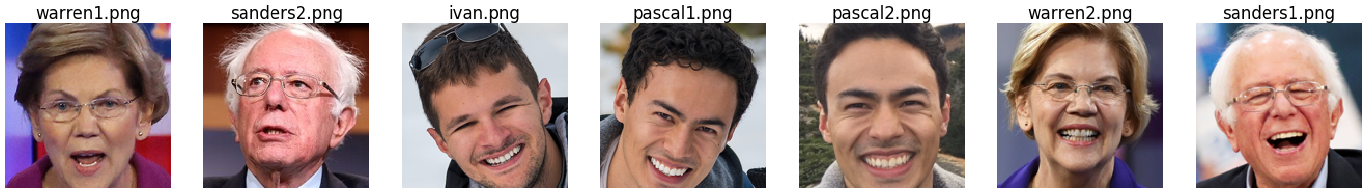

In [7]:
mpl.rcParams['figure.dpi'] = 50
fig, axs = plt.subplots(1, len(images), figsize=(5 * len(images), 5))
for i in range(len(images)):
    axs[i].imshow(images[i])
    axs[i].set_title(image_files[i], fontsize=24)
    axs[i].axis('off')

## Computing Embeddings
Finally, we compute the embeddings and pairwise distances of the images. We can see that the model is able to distinguish the same identity from different identities!

In [8]:
image_batch = tf.convert_to_tensor(np.array(images_whitened))

In [9]:
embedding_batch = model.predict(image_batch)
normalized_embedding_batch = l2_normalize(embedding_batch)

In [17]:
np.sqrt(np.sum(np.square(normalized_embedding_batch[0] - normalized_embedding_batch[1])))

1.3902909

In [10]:
pairwise_distance_matrix = pairwise_distances(normalized_embedding_batch)

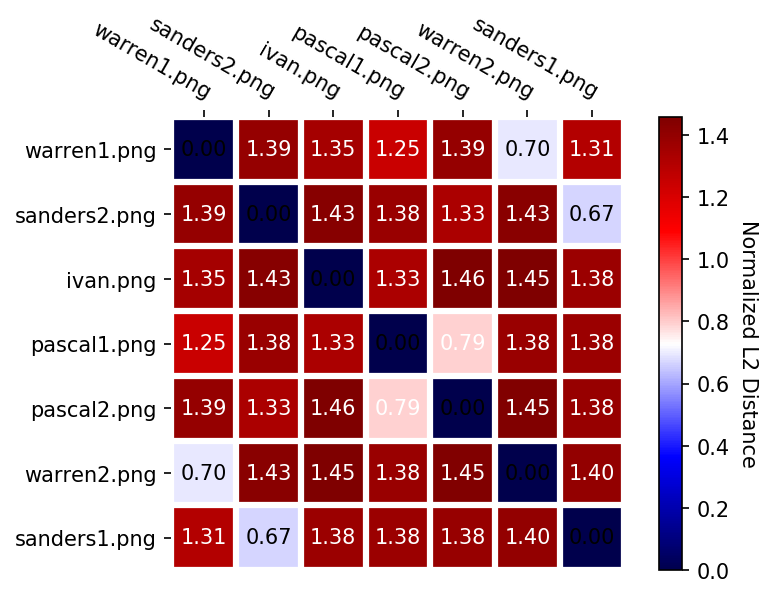

In [11]:
mpl.rcParams['figure.dpi'] = 150
ax, cbar = heatmap(pairwise_distance_matrix,
                   image_files,
                   image_files,
                   cmap="seismic",
                   cbarlabel="Normalized L2 Distance")
texts = annotate_heatmap(ax, valfmt="{x:.2f}")

fig.tight_layout()